loading Roboflow workspace...
loading Roboflow project...
Image saved: input_image.jpg
Detecting people...

0: 416x640 2 persons, 186.7ms
Speed: 7.8ms preprocess, 186.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)
Detecting helmets...


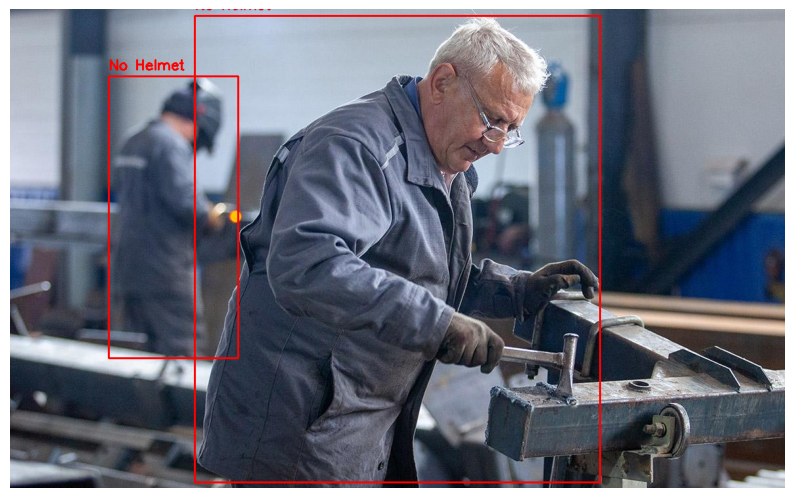

In [18]:
"""
Created by Sander Paju on 19.01.2025 for TalTech (Machine Vision course).
Supervisor: Daniil Valme.

### Program Description:
This program is designed to detect people and helmets in an image using YOLOv8 for person detection
and a pre-trained model from Roboflow for helmet detection. The program performs the following steps:

1. **Library Installation**:
   Install required libraries (`ultralytics`, `roboflow`, `opencv-python`, `pillow`, `matplotlib`).

2. **Model Loading**:
   - Load the YOLOv8 model for detecting people (`person_model`).
   - Use Roboflow's API to load the helmet detection model (`helmet_model`).

3. **Image Download**:
   - Download the input image from a URL using the `download_image` function.
   - Save the image locally for further processing.

4. **Detection Process**:
   - Detect people using the YOLOv8 model. Extract bounding boxes for detected persons.
   - Detect helmets using the Roboflow model. Extract bounding boxes for helmets.

5. **Logic to Link Helmets to People**:
   - Iterate through detected person bounding boxes.
   - Check if each person's bounding box intersects with any helmet bounding box.
   - Mark the person as "Helmet" or "No Helmet" based on the intersection.

6. **Visualization**:
   - Draw bounding boxes for people and helmets on the image.
   - Annotate the boxes with labels and colors:
     - Green (`Helmet`) for persons with helmets.
     - Red (`No Helmet`) for persons without helmets.
     - Blue for helmet bounding boxes.

7. **Display Results**:
   - Display the annotated image using Matplotlib.

### Key Conditional Logic:
- If the image fails to download, the program terminates.
- If a helmet box partially intersects a person's bounding box, the person is marked as wearing a helmet.
"""

# Install required libraries
!pip install ultralytics roboflow opencv-python pillow matplotlib

# Import necessary libraries
from ultralytics import YOLO
from roboflow import Roboflow
import cv2
import matplotlib.pyplot as plt
import requests

# Load YOLOv8 model for person detection
person_model_path = "/content/yolov8n.pt"
person_model = YOLO(person_model_path)

# Load Roboflow model for helmet detection
rf = Roboflow(api_key="RXzvK9yBKBLMuGwRVjtI")
project = rf.workspace().project("helmet-tracking")
helmet_model = project.version(1).model

# Function to download an image from a URL
def download_image(url, save_path="input_image.jpg"):
    """
    Downloads an image from the provided URL and saves it locally.
    :param url: URL of the image to download
    :param save_path: Local path to save the downloaded image
    :return: Path to the saved image or None if the download fails
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, "wb") as file:
            file.write(response.content)
        print(f"Image saved: {save_path}")
        return save_path
    else:
        print(f"Failed to download image: {url}")
        return None

# Function to detect people and helmets in an image
def detect_people_and_helmets(image_url):
    """
    Detects people and helmets in the provided image and annotates the results.
    :param image_url: URL of the input image
    """
    # Step 1: Download the image
    image_path = download_image(image_url)
    if not image_path:  # Terminate if the image download fails
        return

    # Step 2: Load the image with OpenCV
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Step 3: Detect people using YOLOv8
    print("Detecting people...")
    person_results = person_model.predict(image_rgb, conf=0.5, classes=[0])  # Class 0 corresponds to "person"
    person_boxes = [box.xyxy.tolist() for box in person_results[0].boxes]

    # Step 4: Detect helmets using the Roboflow model
    print("Detecting helmets...")
    helmet_result = helmet_model.predict(image_path, confidence=40, overlap=30).json()
    helmet_boxes = []
    for prediction in helmet_result["predictions"]:
        helmet_boxes.append([
            int(prediction["x"] - prediction["width"] / 2),
            int(prediction["y"] - prediction["height"] / 2),
            int(prediction["x"] + prediction["width"] / 2),
            int(prediction["y"] + prediction["height"] / 2)
        ])

    # Step 5: Associate helmets with people
    for person_box in person_boxes:
        x1, y1, x2, y2 = map(int, person_box[0])
        has_helmet = False

        for helmet_box in helmet_boxes:
            hx1, hy1, hx2, hy2 = helmet_box

            # Check for intersection between person and helmet boxes
            intersection_x1 = max(x1, hx1)
            intersection_y1 = max(y1, hy1)
            intersection_x2 = min(x2, hx2)
            intersection_y2 = min(y2, hy2)

            # Determine if the intersection area is valid (greater than 0)
            if intersection_x1 < intersection_x2 and intersection_y1 < intersection_y2:
                has_helmet = True
                break

        # Set annotation color and label based on helmet status
        color = (0, 255, 0) if has_helmet else (0, 0, 255)  # Green for "Helmet", Red for "No Helmet"
        label = "Helmet" if has_helmet else "No Helmet"

        # Draw bounding box and label for the person
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # Step 6: Draw bounding boxes for helmets
    for helmet_box in helmet_boxes:
        hx1, hy1, hx2, hy2 = helmet_box
        cv2.rectangle(image, (hx1, hy1), (hx2, hy2), (255, 255, 0), 2)  # Blue for helmets
        cv2.putText(image, "Helmet", (hx1, hy1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

    # Step 7: Display the annotated image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Example usage
image_url = "https://s0.rbk.ru/v6_top_pics/media/img/8/76/347339146171768.jpeg"  # Replace with your image URL
detect_people_and_helmets(image_url)